In [1]:
import numpy as np
import pandas as pd
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from astropy.time import Time
from astroquery.jplhorizons import Horizons
import rebound

In [134]:
def Furnisher(k):
    '''
    This function is used to load all kernels needed in an operation.
    Comment out kernels not in use and add the ones in use.
    
    Arguments: NA
    Returns: NA
    
    '''
    spice.kclear()
    spice.furnsh('/Users/user/Downloads/naif0008.tls.txt')
    if k == '310+341+435':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310+341':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '310+435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341+435':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    pass

In [118]:
def get_spice_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are 'NONE', 'LT','LT+S'
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        
        radec: numpy array
        
        The right ascension and declination of the observed object
        """
        
        state,lighttime = spice.spkezr(name,t,'J2000',cor,loc)
        pos,lighttime = spice.spkpos(name,t,'J2000',cor,loc)
        range,ra,dec = spice.recrad(pos) 
        xyz = np.array([state[0],state[1],state[2]])/149597870.7#6.68459e-9
        uvw = np.array([state[3],state[4],state[5]])/149597870.7*24.*3600.#*6.68459e-9
        radec = np.array([ra,dec])
        return xyz,uvw,radec*180/np.pi
    return get_target_xyz

Relevant kernels for jupiter.

In [119]:
Furnisher("310+341+435")

In [120]:
def get_astroquery_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are "geometric","astrometric" and 
    "apparent"
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        """
        
        obj = Horizons(id = name, location = loc, epochs = t, id_type = 'majorbody')
        obj1 = obj.vectors(aberrations = cor, refplane = 'earth')
        xyz = np.array([float(obj1['x']),float(obj1['y']),float(obj1['z'])])
        uvw = np.array([float(obj1['vx']),float(obj1['vy']),float(obj1['vz'])])
        obj2 = obj.ephemerides(refsystem = 'J2000', extra_precision = True)
        radec = np.array([float(obj2['RA']),float(obj2['DEC']),float(obj1['range'])])
        return xyz,uvw,radec
    return get_target_xyz  

In [121]:
def monthToNum(shortMonth):
    
    '''
    
    Returns the name of a month that a number corresponds to and vice versa
    
    Arguments:
    
    shortMonth: str
    
    Either the first three letters of a month or its number (e.g. 01 for January, 10 for October)
    
    Returns:
    
    shortMonth: str
    
    Either the first three letters of a month or its number (e.g. 01 for January, 10 for October),
    the other one to the one that was given as an argument
    
    '''
    
    return{
        'Jan' : '01', 'Feb' : '02','Mar' : '03','Apr' : '04','May' : '05','Jun' : '06','Jul' : '07','Aug' : '08',
        'Sep' : '09', 'Oct' : '10','Nov' : '11','Dec' : '12','01' : 'Jan','02' : 'Feb','03' : 'Mar','04' : 'Apr',
        '05' : 'May','06' : 'Jun','07' : 'Jul','08' : 'Aug','09' : 'Sep', '10' : 'Oct','11' : 'Nov','12' : 'Dec'}[shortMonth]

In [122]:
def JD_to_SpiceJD(jd):
    '''
    
    Converts jd date to spice units of time.
    
    Arguments:
    
    jd: float
    
    A jd time in days
    
    Returns:
    
    newjd: float
    
    A spice usable time in seconds
    
    
    '''
    t = Time(jd, format='jd', scale='utc')
    k = t.fits
    print(k)
    year = k[0:4]
    month = k[5:7]
    day = k[8:10]
    hours = k[11:13]
    minutes = k[14:16]
    seconds = k[17:23]
    newmnth = monthToNum(month)
    utc = newmnth + ' ' + day + ", " + year
    newjd = spice.str2et(utc) + int(hours)*3600 + int(minutes)*60 + float(seconds)
    return newjd

In [123]:
def SimStart2(t,bsolar,msolar,iJovian,Ms):
    '''
    Starts the simulation. Adds all particles
    
    Arguments:
    
    bsolar: list of strs
    
    The names of the bodies added. Typically: '1','2','3','4', 'Jupiter','Io','Ananke'. 'Jupiter' must be added
    last followed by the satellites in the system
    
    msolar: list of floats
    
    The masses of the bodies in bsolar. Must be at the order of bsolar
    
    iJovian: list, int
    
    The indexes (+1) that the satellites in the solar system have in bsolar
    
    '''
    
    sim = rebound.Simulation()
    k = np.sqrt(Ms*10**9)*(1.49597870700*10**11)**(-1.5) *86400.00000
    sim.G = k**2
    sim.add(m=1.)
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SUN')
        xyz,uvw,radec = get_planet(t)
        xyz = xyz
        #uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            ps[j].calculate_orbit(primary=ps[0])
        elif bsolar[j-1] == 'Moon':
            ps[j].calculate_orbit(primary=ps[bsolar.index('Earth')+1])
        else:
            if 'Jupiter' in bsolar:
                ps[j].calculate_orbit(primary=ps[bsolar.index('Jupiter')+1])
            else:
                ps[j].calculate_orbit(primary=ps[bsolar.index('5')+1])
    sim.move_to_com()
    jupcom = sim.calculate_com(first=8)
    print(jupcom-sim.particles[3])
    return ps,sim

In [124]:
def Integrator(t,bsolar,msolar,iJovian,body1,body2,Ms):
    '''
    Integrates the system. If body1 or body2 refer to the Jupiter Barycenter, while there are bodies in the Jovian system
    teh function will compute the barycenter in the simulation
    
    Arguments:
    
    bsolar
    msolar
    iJovian
    
    body1 and body2: name in str
    
    The spice names of the bodies that we want to look into to check the error of our integrator
    
     '''
    ps,sim = SimStart2(t,bsolar,msolar,iJovian,Ms)
    xm = []
    ym = []
    zm = []
    xan = []
    yan = []
    zan = []
    distance = []
    Nout = 1000
    year = 365.25 # days
    day = 86400 # s
    tmax = 40*year
    t0 = t
    times = np.linspace(0, tmax, Nout) # days
    x = np.zeros((len(bsolar)+1,Nout))
    y = np.zeros((len(bsolar)+1,Nout))
    z = np.zeros((len(bsolar)+1,Nout))
    get_ear_an = get_spice_function(body1,'NONE',body2)
    for i, time in enumerate(times):
        tspice = t0 + time*day
        sim.integrate(time)
        if body2 == '5' and len(iJovian)>1 :
                jupcom = sim.calculate_com(first=bsolar.index('Jupiter')+1)
                xan.append(ps[bsolar.index(body1)+1].x - jupcom.x)
                yan.append(ps[bsolar.index(body1)+1].y - jupcom.y)
                zan.append(ps[bsolar.index(body1)+1].z - jupcom.z)
        elif body1 == '5' and len(iJovian)>1:
                jupcom = sim.calculate_com(first=bsolar.index('Jupiter')+1)
                xan.append(jupcom.x - ps[0].x)
                yan.append(jupcom.y - ps[0].y)
                zan.append(jupcom.z - ps[0].z)
        else:    
                xan.append(0)
                yan.append(0)
                zan.append(0)
        for j in range(0,len(bsolar)+1):
            x[j][i] = ps[j].x   # This stores the data which allows us to plot it later
            y[j][i] = ps[j].y
            z[j][i] = ps[j].z
        xyz,uvw,radec = get_ear_an(tspice)
        xm.append(xyz[0])
        ym.append(xyz[1])
        zm.append(xyz[2])
        distance.append(np.sqrt(xm[i]**2 + ym[i]**2 + zm[i]**2))
    return x,y,z,xm,ym,zm,times,distance,xan,yan,zan

In [125]:
def ErrorSource(t,bsolar,mass,iJovian,body1,body2,Ms):
    '''
    Returns the error of the chosen bodies as well as the entire system
    
    '''
    x,y,z,xm,ym,zm,times,distance,xan,yan,zan = Integrator(t,bsolar,mass,iJovian,body1,body2,Ms)
    if (body2 == '5' or body1 == '5') and len(iJovian)>1:
        dist1 = np.array(xan)
        dist2 = np.array(yan)
        dist3 = np.array(zan)
    elif body2 == 'Sun':
        temp = 0
        dist1 = x[bsolar.index(body1)+1] - x[temp]
        dist2 = y[bsolar.index(body1)+1] - y[temp]
        dist3 = z[bsolar.index(body1)+1] - z[temp]
    else:
        temp = bsolar.index(body2)+1
        dist1 = x[bsolar.index(body1)+1] - x[temp]
        dist2 = y[bsolar.index(body1)+1] - y[temp]
        dist3 = z[bsolar.index(body1)+1] - z[temp]
    return np.array(dist1-xm),np.array(dist2-ym),np.array(dist3-zm),times,distance,x,y,z,xm,ym,zm,xan,yan,zan

In [126]:
# From 432 (km^3/s^2)
GMEarth = 398600.435420
GMMoon = 27068703.151194

GMMercuryB = 22031.780000
GMVenusB = 324858.592000
GMEarthB = 403503.235502
GMMarsB = 42828.375214
GMJupiterB = 126712764.133446
GMSaturnB = 37940585.200000
GMUranusB = 5794556.465752
GMNeptuneB = 6836527.100580
GMSun = 132712440041.939400 # Just Sun
GMSunterr = GMSun + GMMercuryB + GMVenusB + GMEarthB + GMMarsB

# From 310

GMJupiter = 1.266865341960128E+08
GMIo = 5.959924010272514E+03
GMEuropa = 3.202739815114734E+03
GMGanymede = 9.887819980080976E+03
GMCallisto = 7.179304867611079E+03
GMAmalthea = 1.487604677404272E-01
GM10310 = 1.327132332639000E+11

GMSaturnB310 = 3.794058500000000E+07
GMUranusB310 = 5.794548600000000E+06
GMNeptuneB310 = 6.836527100580000E+06
GMJupiterB310 = 1.267127641334463E+08

In [127]:
MMercuryB = GMMercuryB/GMSun
MVenusB = GMVenusB/GMSun
MEarthB = GMEarthB/GMSun
MEarth = GMEarth/GMSun
MMoon = GMMoon/GMSun
MMarsB = GMMarsB/GMSun
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
MSaturnB = GMSaturnB/GMSun
MUranusB = GMUranusB/GMSun
MNeptuneB = GMNeptuneB/GMSun
MIo = GMIo/GMSun
MEuropa = GMEuropa/GMSun
MGanymede = GMGanymede/GMSun
MCallisto = GMCallisto/GMSun
MAmalthea = GMAmalthea/GMSun

In [128]:
ts = 2452993.114031909
t = JD_to_SpiceJD(ts)

2003-12-19T14:44:12.357(UTC)


The time of the beginning of integration is very important in the predicted error. At the initial time, the furthest away the satellite is from Jupiter the higher the long-term accuracy. We believe this is because of the effect of the gravitational moments of Jupiter on Ananke which the integrator does not take into account

2003-12-19T14:44:12.357(UTC)
125117116.54054108
<rebound.Particle object, m=0.0009517514775406745 x=-6.007774801045788 y=-1.0967423174334467 z=-0.34130910585937746 vx=0.014726948234581759 vy=-0.015612466936564134 vz=-0.006745188617865022>
CPU times: user 23.9 s, sys: 34.3 ms, total: 24 s
Wall time: 24 s


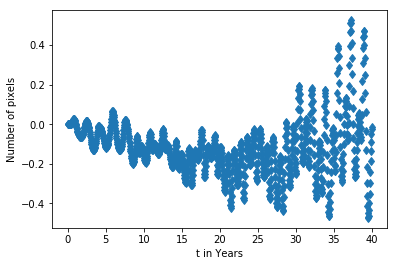

In [167]:
%%time
Furnisher('310+341+435')
ts = 2452993.114031909
t = JD_to_SpiceJD(ts)
print(t)
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,zerr,times,distance,x,y,z,xm,zm,ym,xan,yan,zan = ErrorSource(140961664.18440723+150*3600*24,['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0],[9,10,11,12,13,14,15],'Ananke','5',GMSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
#plt.plot(times/365.24,(yerr)*1e6/4.5,"d",color = "red")
#plt.plot(times/365.24,(zerr)*1e6/4.5,"d",color = "green")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

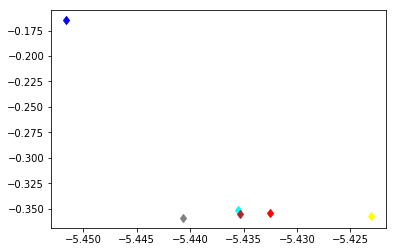

In [181]:
plt.plot(x[-1][0],y[-1][0],"d",color = "blue")
plt.plot(x[-2][0],y[-2][0],"d",color = "yellow")
plt.plot(x[-3][0],y[-3][0],"d",color = "gray")
plt.plot(x[-4][0],y[-4][0],"d",color = "cyan")
plt.plot(x[-5][0],y[-5][0],"d",color = "red")
plt.plot(x[-6][0],y[-6][0],"d",color = "brown")

If the integrator starts at about 1000 days after the time used above the error increases by a factor of 4 

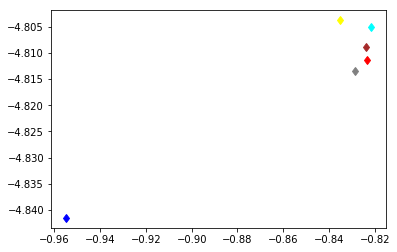

In [188]:
plt.plot(x[-1][69],y[-1][69],"d",color = "blue")
plt.plot(x[-2][69],y[-2][69],"d",color = "yellow")
plt.plot(x[-3][69],y[-3][69],"d",color = "gray")
plt.plot(x[-4][69],y[-4][69],"d",color = "cyan")
plt.plot(x[-5][69],y[-5][69],"d",color = "red")
plt.plot(x[-6][69],y[-6][69],"d",color = "brown")


In [187]:
distance[0],distance[69]

(0.19092177551701553, 0.1419065437770904)

In [136]:
myra,mydec,spra,spdec = [],[],[],[]
get_ear_an = get_spice_function('5','LT','3')
for i in range(0,len(xm)):
    xyz,uvw,radec = get_ear_an(times[i]+t)
    dist, ra, dec = spice.recrad(np.array([float(-xm[i]-xerr[i]+xyz[0]),float(-ym[i]-yerr[i]+xyz[1]),float(-zm[i]-zerr[i]+xyz[2])]))
    myra.append(ra)
    mydec.append(dec)
    dist, ra, dec = spice.recrad(np.array([float(-xm[i]+xyz[0]),float(-ym[i]+xyz[1]),float(-zm[i]+xyz[2])]))
    spra.append(ra)
    spdec.append(dec)    

In [137]:
errra = np.array(myra)-np.array(spra)
errdec = np.array(mydec)-np.array(spdec)

Text(0.5,0,'t in Years')

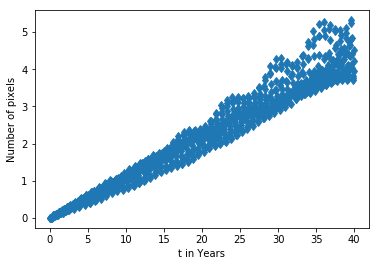

In [132]:
plt.plot(times/365.24,(1e6*np.sqrt(errra**2+errdec**2)),"d")
#plt.plot(times/365.24,(1e6*errra),"d")
#plt.plot(times/365.24,(1e6*errdec),"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

In [112]:
ts = 2452993.114031909+40*365.25
get_pans = get_astroquery_function('5','astrometric','f51')
vecs2 = get_pans(ts)
vectors = vecs2[0]+np.array([xan[-1],yan[-1],zan[-1]])
xyz = vectors/6.68459e-9
xyz1 = np.array([xyz[0],xyz[1],(xyz[2]-np.sin(20.707222)*4.25875e-5)])
vectors = vecs2[0]+np.array([xan[-1]+xerr[-1],yan[-1]+yerr[-1],zan[-1]]+zerr[-1])
xyz = vectors/6.68459e-9
xyz2 = np.array([xyz[0],xyz[1],(xyz[2]-np.sin(20.707222)*4.25875e-5)])
dist, ra1,dec1 = spice.recrad(xyz1)
dist, ra2,dec2 = spice.recrad(xyz2)
ra1*180/np.pi,ra2*180/np.pi,dec1*180/np.pi,dec2*180/np.pi

(280.6624122286894,
 280.66266936869835,
 -22.708121354489126,
 -22.708102491438485)

In [113]:
def FinderSpicef51(name,t):
    '''
    
    Finds the radec of objects in the jovian system from the pansstars observatory
    
    Arguments:
    
    name: str
    
    The name of the object in spice documentation. See Summary_Names.txt
    
    t: float
    
    A julian date
    
    '''
    get_pans = get_astroquery_function('5','astrometric','f51')
    vecs2 = get_pans(t)
    ts = JD_to_SpiceJD(t)
    get_obj = get_spice_function(name,"NONE","5")
    vecs = get_obj(ts)
    vectors = vecs2[0]+vecs[0]
    xyz = vectors/6.68459e-9
    xyz = np.array([xyz[0],xyz[1],(xyz[2]-np.sin(20.707222)*4.25875e-5)])
    range, ra, dec = spice.recrad(xyz)
    return np.array([ra,dec])*180/np.pi

Returns the position of a satellite after 40 years of integration (By taking its position 40 years prior and predicting it at the time given)

In [114]:
def FinderReboundf51(name,ts):
    '''
    
    Finds the radec of objects in the jovian system from the pansstars observatory
    
    Arguments:
    
    name: str
    
    The name of the object in spice documentation. See Summary_Names.txt
    
    t: float
    
    A julian date
    
    '''
    Furnisher('310+341+435')
    t = JD_to_SpiceJD(ts-40*365.25)
    MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
    xerr,yerr,zerr,times,distance,x,y,z,xm,zm,ym,xan,yan,zan = ErrorSource(t,['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto',name],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0],[9,10,11,12,13,14,15],name,'5',GMSun)
    get_pans = get_astroquery_function('5','astrometric','f51')
    vecs2 = get_pans(ts)
    vectors = vecs2[0]+np.array([xan[-1],yan[-1],zan[-1]])
    xyz = vectors/6.68459e-9
    xyz1 = np.array([xyz[0],xyz[1],(xyz[2]-np.sin(20.707222)*4.25875e-5)])
    range, ra, dec = spice.recrad(xyz1)
    return np.array([ra,dec])*180/np.pi



In [115]:
%%time
FinderReboundf51('Elara',2452993.114031909)

1963-12-19T14:44:12.357(UTC)
<rebound.Particle object, m=0.0009517514775406745 x=4.562479371689504 y=0.8119566516881653 z=0.2313273789383568 vx=0.014605305494403257 vy=0.00612411527536472 vz=0.002692062838762231>
CPU times: user 25.7 s, sys: 72.5 ms, total: 25.8 s
Wall time: 26.9 s


array([168.8365571 ,   5.75386356])

In [116]:
FinderSpicef51('Elara',2452993.114031909)

2003-12-19T14:44:12.357(UTC)


array([168.83662306,   5.754119  ])